In [13]:
import json
import io
import numpy as np
import re

# data
import pandas as pd
import geopandas as gpd
import shapely
import duckdb as ddb
from scipy import io as io
import nctoolkit as nc
import xarray as xr
import rioxarray as rx
import glob
import ibis as ib
from ibis import _
ib.options.interactive = True

# plots

from datashader import transfer_functions as tf, reductions as rd
import pypalettes
import pydeck as pdk

In [3]:
# get the filenames from the ghsl folder
nc_paths = glob.glob("datasets/doi_10_5061_dryad_dk1j0__v20200213/*.nc")
nc_paths

['datasets/doi_10_5061_dryad_dk1j0__v20200213/GDP_per_capita_PPP_1990_2015_v2.nc',
 'datasets/doi_10_5061_dryad_dk1j0__v20200213/HDI_1990_2015_v2.nc',
 'datasets/doi_10_5061_dryad_dk1j0__v20200213/pedigree_HDI_1990_2015_v2.nc',
 'datasets/doi_10_5061_dryad_dk1j0__v20200213/pedigree_GDP_per_capita_PPP_1990_2015_v2.nc',
 'datasets/doi_10_5061_dryad_dk1j0__v20200213/GDP_PPP_30arcsec_v3.nc',
 'datasets/doi_10_5061_dryad_dk1j0__v20200213/GDP_PPP_1990_2015_5arcmin_v2.nc',
 'datasets/doi_10_5061_dryad_dk1j0__v20200213/admin_areas_GDP_HDI.nc']

### Data from

https://datadryad.org/stash/dataset/doi:10.5061/dryad.dk1j0


In [4]:
# Method to plot polygons taken from: https://thedatasavvycorner.com/blogs/10-pydeck-with-gpd

# common paremeters to the deck maps
lat_center = 0
lon_center = 0

view_state = pdk.ViewState(latitude=lat_center
                           ,longitude=lon_center
                           ,zoom=1
                           ,bearing=0
                           ,pitch=0)




In [5]:
sel = nc_paths[1]
wdi = rx.open_rasterio(sel)
sel

'datasets/doi_10_5061_dryad_dk1j0__v20200213/HDI_1990_2015_v2.nc'

In [6]:
wdi

<xarray.DataArray 'HDI' (time: 26, y: 2160, x: 4320)> Size: 970MB
[242611200 values with dtype=float32]
Coordinates:
  * time         (time) float64 208B 1.99e+03 1.991e+03 ... 2.014e+03 2.015e+03
  * x            (x) float64 35kB -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * y            (y) float64 17kB 89.96 89.88 89.79 ... -89.79 -89.88 -89.96
    spatial_ref  int64 8B 0
Attributes: (12/22)
    latitude#axis:            Y
    latitude#long_name:       latitude
    latitude#standard_name:   latitude
    latitude#units:           degrees_north
    longitude#axis:           X
    longitude#long_name:      longitude
    ...                       ...
    NETCDF_DIM_time_VALUES:   [1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997...
    long_name:                Human Development Index (HDI)
    units:                    ('dimensionless indicator', 'dimensionless indi...
    _FillValue:               -9.0
    scale_factor:             1.0
    add_offset:               0.0

In [7]:
wdi_sub=wdi.sel(time=2015)

In [8]:
wdi_df = wdi_sub.to_pandas().melt(ignore_index=False).rename(columns={"value":"value_var"}).query("value_var>=0").reset_index()

In [9]:
wdi_df

,y,x,value_var
0,71.541669,-179.958328,0.766868
1,71.458335,-179.958328,0.766868
2,71.375002,-179.958328,0.766868
3,71.291669,-179.958328,0.766868
4,71.208335,-179.958328,0.766868
...,...,...,...
2263970,-16.875000,179.958328,0.736000
2263971,-16.958334,179.958328,0.736000
2263972,-17.041667,179.958328,0.736000
2263973,-18.541667,179.958328,0.736000


In [10]:
wdi.shape

(26, 2160, 4320)

In [11]:
wdi.isel()

<xarray.DataArray 'HDI' (time: 26, y: 2160, x: 4320)> Size: 970MB
[242611200 values with dtype=float32]
Coordinates:
  * time         (time) float64 208B 1.99e+03 1.991e+03 ... 2.014e+03 2.015e+03
  * x            (x) float64 35kB -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * y            (y) float64 17kB 89.96 89.88 89.79 ... -89.79 -89.88 -89.96
    spatial_ref  int64 8B 0
Attributes: (12/22)
    latitude#axis:            Y
    latitude#long_name:       latitude
    latitude#standard_name:   latitude
    latitude#units:           degrees_north
    longitude#axis:           X
    longitude#long_name:      longitude
    ...                       ...
    NETCDF_DIM_time_VALUES:   [1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997...
    long_name:                Human Development Index (HDI)
    units:                    ('dimensionless indicator', 'dimensionless indi...
    _FillValue:               -9.0
    scale_factor:             1.0
    add_offset:               0.0

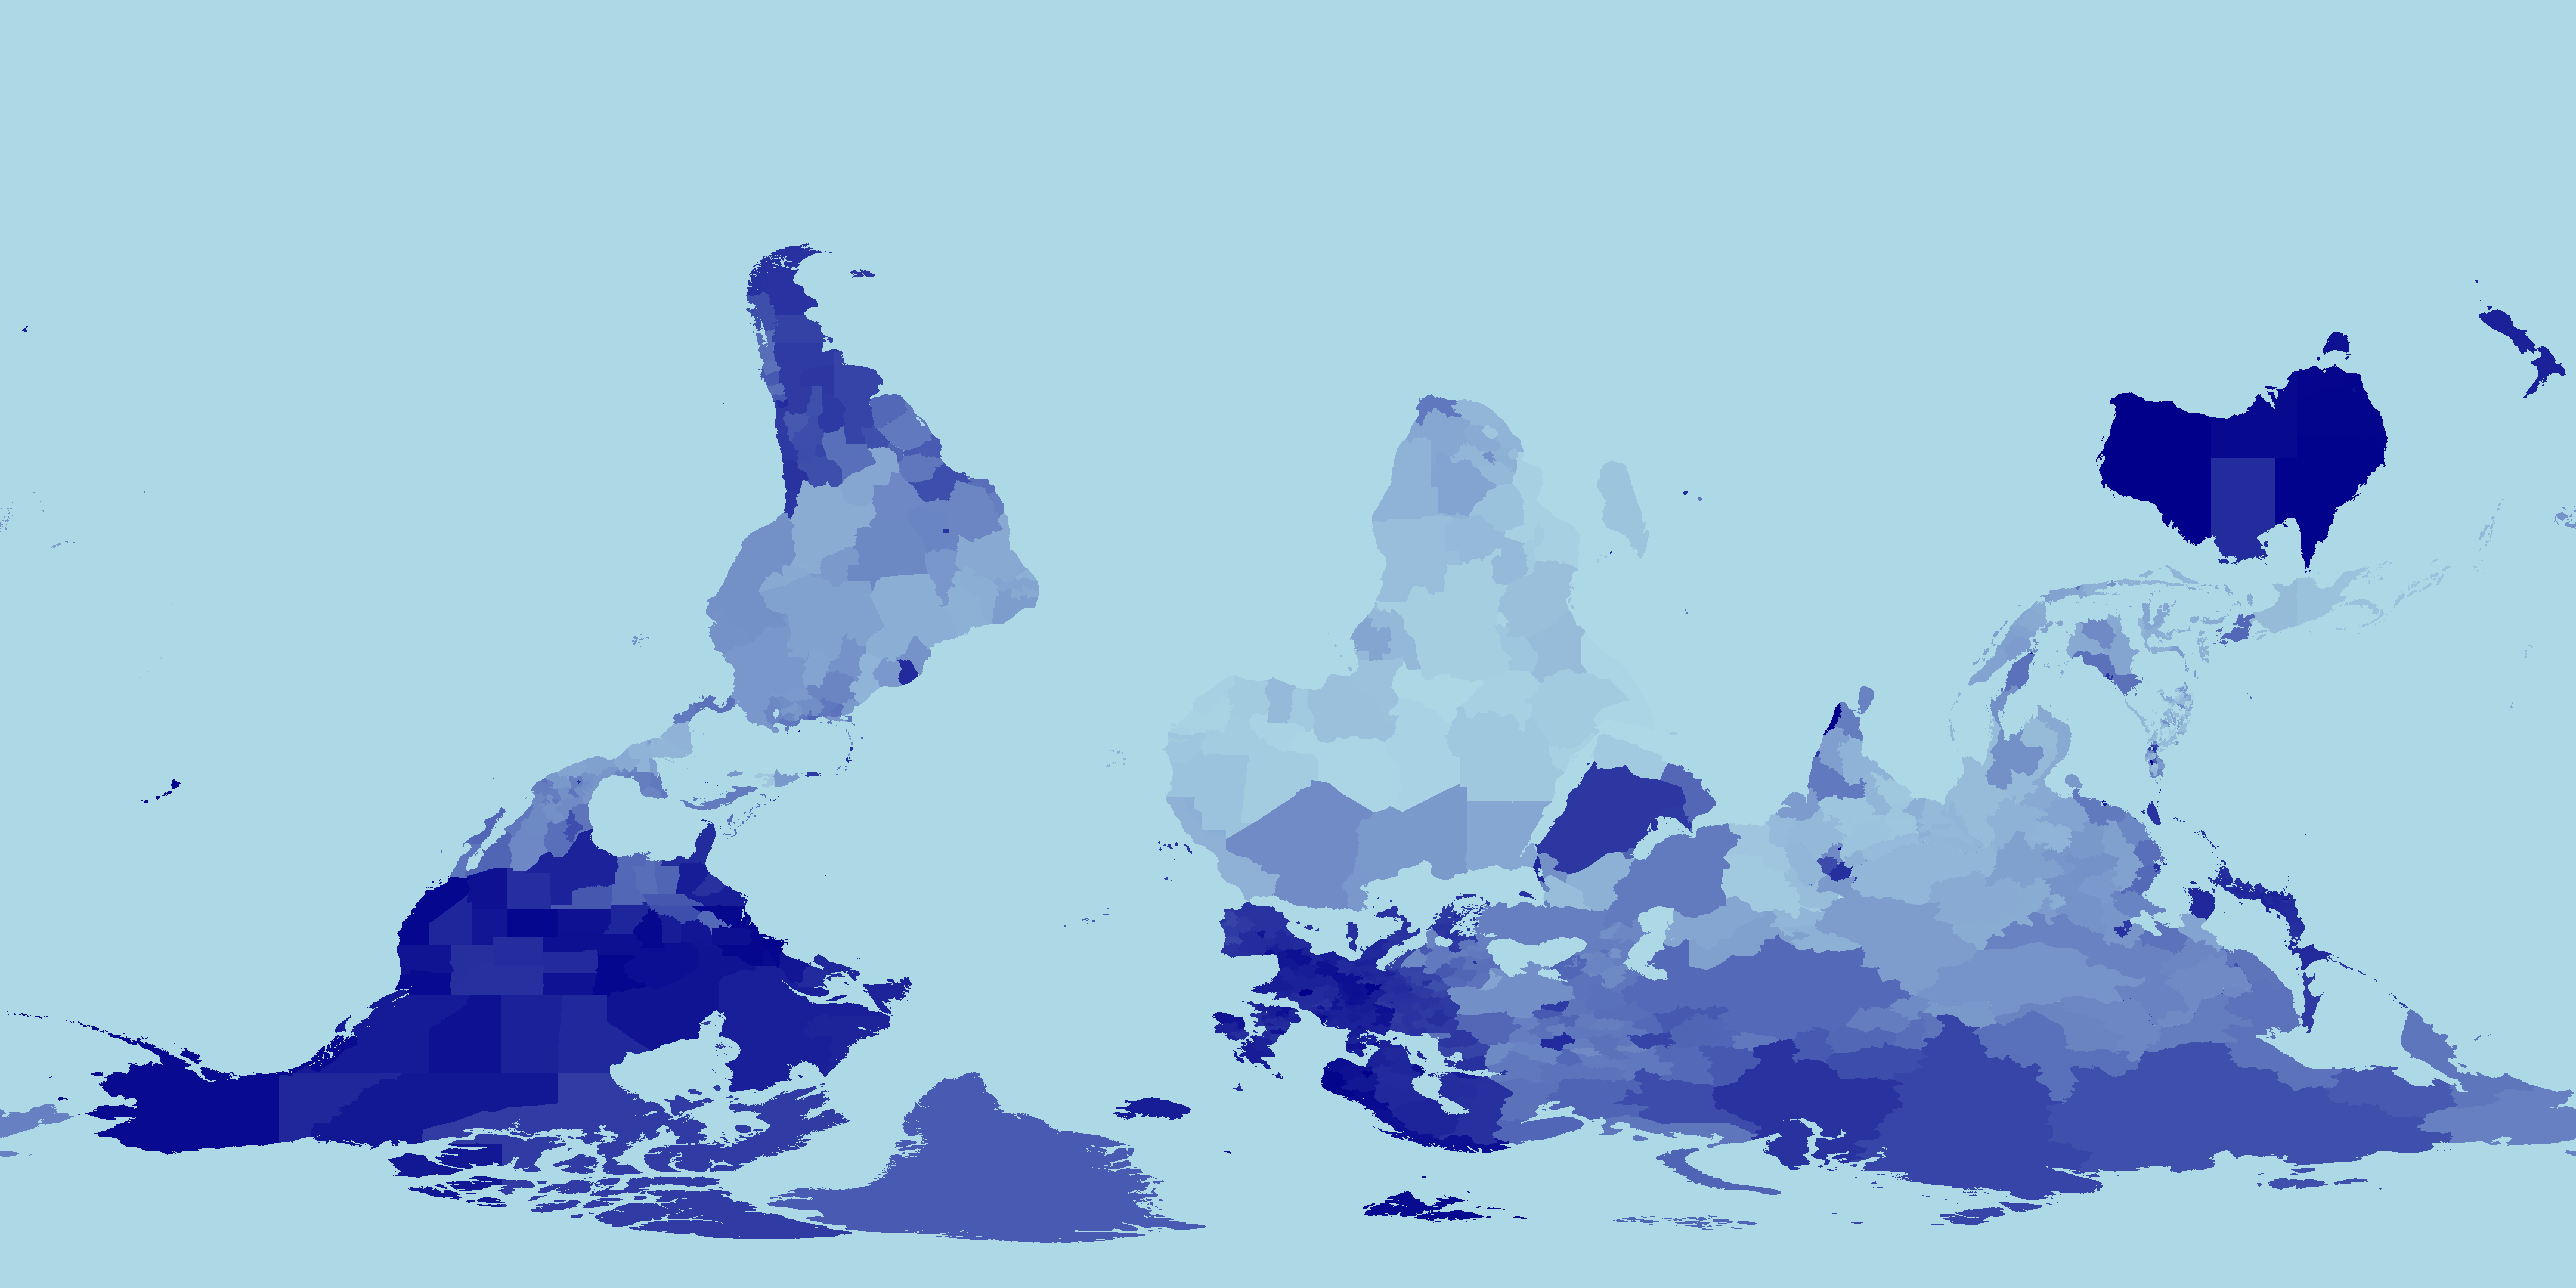

In [12]:
# how to put it in the right orientation ? 
#  
tf.shade(wdi[25,])

In [13]:
# wdi_df = wdi.to_dataframe()

In [14]:
valid_frac = wdi_df.query("value_var>0").shape[0]/wdi_df.shape[0]

print(f"Fraction of data set : {valid_frac:.2f}")

Fraction of data set : 1.00


In [15]:
print(wdi_df.shape)
wdi_df.head(3)

(2263975, 3)


,y,x,value_var
0,71.541669,-179.958328,0.766868
1,71.458335,-179.958328,0.766868
2,71.375002,-179.958328,0.766868


In [16]:
import h3

In [18]:
wdi_df["h3_id"] = wdi_df.apply(lambda row: h3.latlng_to_cell(lat=row["y"],lng=row["x"],res=8),axis=1)

<Axes: >

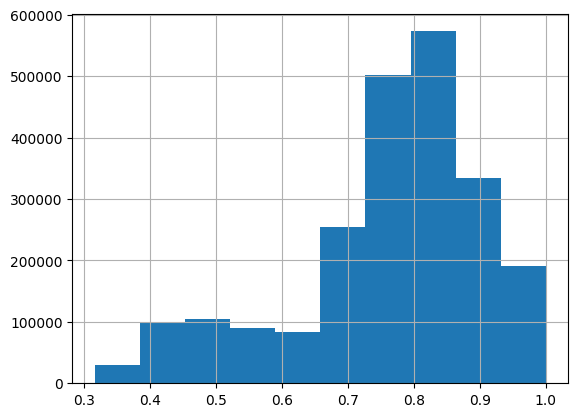

In [81]:
wdi_df.value_var.hist()

In [ ]:
# # ibis workflow, not efficient
# wdi_ib = ib.memtable(wdi_df) 
# wdi_ib = wdi_ib.fill_null(0)
# wdi_ib.filter(_.HDI>0,_.time==2015)
# wdi_2015_df = wdi_ib.filter(_.HDI>0,_.time==2015).to_pandas()
# wdi_2015_df.head(5)

# print(wdi_2015_df.shape)

# wdi_max = wdi_2015_df.HDI.max()
# wdi_max

In [29]:
# Centroids, plotted other HDI 
# layer_hdi = pdk.Layer(
#     "ScatterplotLayer",
#     wdi_2015_df,
#     pickable=True,
#     opacity=1,
#     stroked=True,
#     filled=True,
#     extruded=False,
#     auto_highlight=True,
#     radius_scale=1,
#     radius_min_pixels=1,
#     radius_max_pixels=3,
#     line_width_min_pixels=1,
#     get_position = ["longitude","latitude"],
#     get_radius = 50,
#     get_fill_color= '[HDI*255,40,30]',
#     get_line_color=[0, 0, 0]
# )

# view_state = pdk.ViewState(latitude=0, longitude=0, zoom=4, bearing=0, pitch=45)

# # Render
# deck_map_hdi = pdk.Deck(
#     layers=[layer_hdi],
#     initial_view_state=view_state,
#     # tooltip={"text": "{position}\nCount: {count}"},
# )


# deck_map_hdi.to_html("deck_maps/deck_hdi.html")

## Reading the orginal WDI data

In [7]:
wdi_raw = pd.read_csv("datasets/WDI_CSV_2024_06_28/WDICSV.csv"
                    #   ,nrows=1000
                      )

In [8]:
wdi_raw.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023'],
      dtype='object')

In [9]:
wdi_raw.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,17.401410,17.911234,18.463874,18.924037,19.437054,20.026254,20.647969,21.165877,21.863139,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.728819,7.005877,7.308571,7.547226,7.875917,8.243018,8.545483,8.906711,9.261320,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,38.080931,38.422282,38.722108,38.993157,39.337872,39.695279,40.137847,40.522209,41.011132,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,31.860474,33.903800,38.854624,40.199898,43.017148,44.381259,46.264875,48.100862,48.711995,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,17.619475,16.500171,24.605861,25.396929,27.037528,29.137914,31.001049,32.777910,33.747907,NaN


In [10]:
len(wdi_raw["Indicator Code"].unique())

1492

In [11]:
wdi_raw.shape

(396872, 68)

In [12]:
wdi_raw["Indicator Name"].unique()

array(['Access to clean fuels and technologies for cooking (% of population)',
       'Access to clean fuels and technologies for cooking, rural (% of rural population)',
       'Access to clean fuels and technologies for cooking, urban (% of urban population)',
       ...,
       'Women who were first married by age 18 (% of women ages 20-24)',
       "Women's share of population ages 15+ living with HIV (%)",
       'Young people (ages 15-24) newly infected with HIV'], dtype=object)

In [27]:
indicators = wdi_raw["Indicator Name"].unique()

In [48]:
manufacturing_vars = [ x for x in indicators if re.search(pattern="[Mm]anufacturing" ,string=x)]

industry_vars = [ x for x in indicators if re.search(pattern="[Ii]ndustry" ,string=x)]

service_vars = [ x for x in indicators if re.search(pattern="[Ss]ervice" ,string=x)]

agriculture_vars = [ x for x in indicators if re.search(pattern="[Aa]griculture" ,string=x)]

In [49]:
print(len(manufacturing_vars)," : ",manufacturing_vars)
print(len(industry_vars)," : ",industry_vars)
print(len(service_vars)," : ",service_vars)
print(len(agriculture_vars)," : ",agriculture_vars)

16  :  ['Chemicals (% of value added in manufacturing)', 'Child employment in manufacturing (% of economically active children ages 7-14)', 'Child employment in manufacturing, female (% of female economically active children ages 7-14)', 'Child employment in manufacturing, male (% of male economically active children ages 7-14)', 'CO2 emissions from manufacturing industries and construction (% of total fuel combustion)', 'Food, beverages and tobacco (% of value added in manufacturing)', 'Machinery and transport equipment (% of value added in manufacturing)', 'Manufacturing, value added (% of GDP)', 'Manufacturing, value added (annual % growth)', 'Manufacturing, value added (constant 2015 US$)', 'Manufacturing, value added (constant LCU)', 'Manufacturing, value added (current LCU)', 'Manufacturing, value added (current US$)', 'Medium and high-tech manufacturing value added (% manufacturing value added)', 'Other manufacturing (% of value added in manufacturing)', 'Textiles and clothing (

In [50]:
gdp_vars = [ x for x in indicators if re.search(pattern="GDP" ,string=x)]

In [51]:
gdp_vars

['Agriculture, forestry, and fishing, value added (% of GDP)',
 'Broad money (% of GDP)',
 'Central government debt, total (% of GDP)',
 'Claims on central government, etc. (% GDP)',
 'Claims on other sectors of the domestic economy (% of GDP)',
 'CO2 emissions (kg per 2015 US$ of GDP)',
 'CO2 emissions (kg per 2021 PPP $ of GDP)',
 'CO2 emissions (kg per PPP $ of GDP)',
 'Coal rents (% of GDP)',
 'Current account balance (% of GDP)',
 'Current health expenditure (% of GDP)',
 'Discrepancy in expenditure estimate of GDP (constant LCU)',
 'Discrepancy in expenditure estimate of GDP (current LCU)',
 'Domestic credit provided by financial sector (% of GDP)',
 'Domestic credit to private sector (% of GDP)',
 'Domestic credit to private sector by banks (% of GDP)',
 'Domestic general government health expenditure (% of GDP)',
 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
 'Energy use (kg of oil equivalent) per $1,000 GDP (constant 2021 PPP)',
 'Expense (% of GDP)',
 'Expor

In [52]:
countries = wdi_raw["Country Code"].unique()

In [54]:
len(countries)

266

In [55]:
countries

array(['AFE', 'AFW', 'ARB', 'CSS', 'CEB', 'EAR', 'EAS', 'EAP', 'TEA',
       'EMU', 'ECS', 'ECA', 'TEC', 'EUU', 'FCS', 'HPC', 'HIC', 'IBD',
       'IBT', 'IDB', 'IDX', 'IDA', 'LTE', 'LCN', 'LAC', 'TLA', 'LDC',
       'LMY', 'LIC', 'LMC', 'MEA', 'MNA', 'TMN', 'MIC', 'NAC', 'INX',
       'OED', 'OSS', 'PSS', 'PST', 'PRE', 'SST', 'SAS', 'TSA', 'SSF',
       'SSA', 'TSS', 'UMC', 'WLD', 'AFG', 'ALB', 'DZA', 'ASM', 'AND',
       'AGO', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS',
       'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN',
       'BOL', 'BIH', 'BWA', 'BRA', 'VGB', 'BRN', 'BGR', 'BFA', 'BDI',
       'CPV', 'KHM', 'CMR', 'CAN', 'CYM', 'CAF', 'TCD', 'CHI', 'CHL',
       'CHN', 'COL', 'COM', 'COD', 'COG', 'CRI', 'CIV', 'HRV', 'CUB',
       'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY',
       'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FRO', 'FJI', 'FIN',
       'FRA', 'PYF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC',
       'GRL', 'GRD',